Library

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import os
import random
from sklearn import preprocessing
path = os.getcwd()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.DoubleTensor')

DataLoad 

In [2]:
data = pd.read_csv(path + '\\data\\energy.csv',header=0,index_col=0)
data.head(10)

,load,temp
date,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000
2012-01-01 05:00:00,2453.0,31.333333
2012-01-01 06:00:00,2560.0,30.000000
2012-01-01 07:00:00,2719.0,29.000000
2012-01-01 08:00:00,2916.0,29.000000


DataPrepare

In [3]:
# 将序列数据转化为监督模型可训练的数据
def data_to_supervised(data, time_steps, horizion, features = 2):
    column_data = [] # 存放数据
    column_name = [] # 存放column名字
    features = data.shape[1] # 特征个数
    for i in range(time_steps, 0, -1):
        column_data.append(data.shift(periods=i, axis=0))
        if i !=1:
            column_name += ['load(t-'+str(i-1) +')', 'temp(t-' + str(i-1) + ')']
        else:
            column_name += ['load(t)', 'temp(t)']
    for i in range(0,horizion):
        column_data.append(data['load'].shift(periods=-i, axis=0))
        column_name += ['load(t+' + str(i+1) + ')']
    reframed_data = pd.concat(column_data, axis=1)
    reframed_data.columns = column_name
    reframed_data.dropna(how='any', axis=0,inplace=True)
    return reframed_data

In [4]:
time_steps = 5
features = 2
horizion = 1

reframed_data = data_to_supervised(data=data, time_steps=time_steps, horizion=horizion, features = 2)
print(f'name: reframed_data.  type:{type(reframed_data)}  shape:{reframed_data.shape}')

name: reframed_data.  type:<class 'pandas.core.frame.DataFrame'>  shape:(26299, 11)


In [5]:
# 数据标准化
def standardizeData(X, SS=None, train = False):
    '''
    Given a list of input features, standizes them to bring them onto a homsgenous scale
    
    Args:
        X([Dataframe]): [A dataframe of all the input values]
        SS([object],optional): [A standardScaler object that hold mean and std of a standardized dataset] Default is None
        train([bool],optional):[if False, mean validation set to be loaded and SS need to be passed to scale it] Default is False
    '''
    if train:
        SS = StandardScaler()
        new_X = SS.fit_transform(X)
        return (new_X, SS)
    else:
        new_X = SS.fit_transform(X)
        return (new_X, None)

In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
stdData, _ = standardizeData(X=reframed_data, SS=scaler, train = False)
print(f'name:stdDate.  type: {type(stdData)}  shape:{stdData.shape}')

name:stdDate.  type: <class 'numpy.ndarray'>  shape:(26299, 11)


In [7]:
# 将输入输出分开 
inputs = stdData[:,:-1]
outputs = stdData[:,-1]
print(f'inputs.shape:{inputs.shape}')
print(f'outputs.shape:{outputs.shape}')

# 将训练集测试集验证集合分开
num_examples = inputs.shape[0]
train_size = int( num_examples * 0.8 )
valid_size = int( num_examples * 0.1 )
train_ip, train_op = inputs[:train_size, :],outputs[:train_size]
valid_ip, valid_op = inputs[train_size:train_size+valid_size, :],outputs[train_size:train_size+valid_size]
test_ip,test_op = inputs[train_size+valid_size:, :],outputs[train_size+valid_size:]

print('train:')
print(f'train_ip.shape:{train_ip.shape}')
print(f'train_op.shape:{train_op.shape}')
print('valid:')
print(f'valid_ip.shape:{valid_ip.shape}')
print(f'valid_op.shape:{valid_op.shape}')
print('test:')
print(f'test_ip.shape:{test_ip.shape}')
print(f'test_op.shape:{test_op.shape}')

inputs.shape:(26299, 10)
outputs.shape:(26299,)
train:
train_ip.shape:(21039, 10)
train_op.shape:(21039,)
valid:
valid_ip.shape:(2629, 10)
valid_op.shape:(2629,)
test:
test_ip.shape:(2631, 10)
test_op.shape:(2631,)


In [8]:
# 构建自定义的数据集类
class LoadDataset(torch.utils.data.Dataset):
    '''
    This class is the dataset class which is used to load data for training the LSTM 
    to forecast load data
    '''
    def __init__(self,inputs,outputs):
        '''
        Initialize the class with instance variables
        
        Args:
            inputs([list])  :[A list of list representing input parameters, include load and temp]
            outputs([list]) :[A list of floats for the load]
        '''
        super(LoadDataset,self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
    def __len__(self):
        '''
        Return the total number of samples in the datasets
        '''
        return len(self.outputs)
    
    def __getitem__(self, idx):
        '''
        Given an index, it retrieves the input and output corresponding to that index and return the same 
        
        Args:
        idx([int]) :[An integer representing a position in the samples]
        '''
        x = torch.tensor(self.inputs[idx]).requires_grad_(True)
        y  =torch.tensor(self.outputs[idx]).requires_grad_(True)
        
        return(x, y)     

In [9]:
batch_size = 128
trainDataset = LoadDataset(train_ip,train_op)
train_generator = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=128,shuffle=False)

In [10]:
# 将 numpy转为 tensor
def numpy_to_tensor(x,y,device):
    if type(x) is np.ndarray:
        x = torch.tensor(x, dtype=torch.double, device=device)
        y = torch.tensor(y, dtype=torch.double, device=device)
    elif type(x) is torch.tensor:
        pass
    return x, y

In [11]:
valid_x,valid_y = numpy_to_tensor(valid_ip, valid_op, DEVICE)
test_x,test_y = numpy_to_tensor(test_ip,test_op, DEVICE)

Model

In [12]:
class My_LSTM(nn.Module):
    def __init__(self):
        '''
        Initialize the network architecture
        '''
        super(My_LSTM,self).__init__()
        self.lstm1 = nn.LSTM(input_size=2, hidden_size=18, num_layers=1, bias=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=18, hidden_size=12, num_layers=1, bias=True, batch_first=True)
        self.fc = nn.Linear(12,1)
        self.nla = nn.Tanh()
    
    def init_hiddenState(self,batch_size):
        '''
        Initialize the hidden state of RNN to all zeros
        
        Args:
            batch_size:([int]):[because the shape of h_state(or c_state) is (num_layers, batch_size, hidden_size),so it need the parameter batch_size]
        '''
        state1 = (torch.zeros(1, batch_size, 18,dtype = torch.double).requires_grad_().to(DEVICE),
                  torch.zeros(1, batch_size, 18,dtype = torch.double).requires_grad_().to(DEVICE))
        
        state2 = (torch.zeros(1, batch_size, 12,dtype = torch.double).requires_grad_().to(DEVICE),
                  torch.zeros(1, batch_size, 12,dtype = torch.double).requires_grad_().to(DEVICE))
        
        return state1, state2
        
    def forward(self,input_x):
        '''
        Define the forward propogation logic
        
        Args:
            inputs([torch,Tensor]):[A 3-dimensional float tensor containing parameters, (batch_size, seq_len, features)]   
        '''
        state1,state2 = self.init_hiddenState(batch_size=input_x.shape[0])
        # output：contain all of h_state, but h_out only include the last h_state
        output1, _ = self.lstm1(input_x, state1)
        output2, (h_out,_) = self.lstm2(output1, state2) 
        # get the last time hidden_state, there are three ways in following
        # output_last = output[:,-1,:]
        # output_last = h_out[-1] 
        output_last = h_out.view(input_x.shape[0], 12)
        return self.nla(self.fc(output_last))
    
    def predict(self,inputs):
        '''
        Make Prediction for the set of inputs provided and return the same 
        
        Args:
            inputs([torch.Tensor]):[A tensor of input]
        '''
        with torch.no_grad():
            predictions = self.forward(inputs)
        return predictions

In [13]:
model = My_LSTM().to(DEVICE)
loss_func = nn.MSELoss(reduction='sum')
optim = optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

My_LSTM(
  (lstm1): LSTM(2, 18, batch_first=True)
  (lstm2): LSTM(18, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (nla): Tanh()
)


Training

epoch: 0, train_loss:0.03326371660043944 valid_loss:0.036206396718615544
epoch: 10, train_loss:0.0005722015675181719 valid_loss:0.0013486581780756605
epoch: 20, train_loss:0.0004381557747879879 valid_loss:0.001396083894422907
epoch: 30, train_loss:0.00035300894826926214 valid_loss:0.0008003262744850305
epoch: 40, train_loss:0.0003305527688673431 valid_loss:0.0007478922162306931
epoch: 50, train_loss:0.0003059998786260759 valid_loss:0.0007032653998183195
epoch: 60, train_loss:0.0003036621014170185 valid_loss:0.0006777401241848902
epoch: 70, train_loss:0.0003049666787623332 valid_loss:0.000682472494745851
epoch: 80, train_loss:0.00031742849334222793 valid_loss:0.0008340400361001908
epoch: 90, train_loss:0.0003210674845386936 valid_loss:0.0006732734810211527


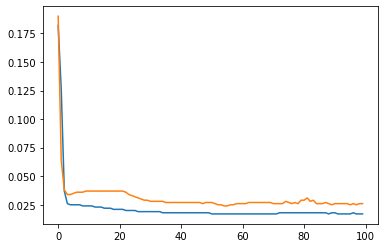

In [14]:
num_epochs = 100
train_losses = []
valid_losses = []
for epoch in range(0,num_epochs):
    
    sample_num = 0 # the sum of the train_set
    ls = 0        # loss of train_set
    valid_ls = 0  # loss of valid_set
    
    for X,Y in train_generator:
        # Perform the forward pass operation
        X = X.view(X.shape[0],time_steps,features).to(DEVICE)
        Y = Y.to(DEVICE)
        Y_hat = model(X)
        # Backpropagate the errors through the network
        loss = loss_func(Y_hat.squeeze(),Y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    
        sample_num += X.shape[0] # calculate the total train samplt
        ls += loss.item()        # calculate the total train error
    ls = ls / sample_num
    
    # check the performance on valiation data
    valid_x = valid_x.view(valid_x.shape[0], time_steps, features).to(DEVICE)
    valid_y.to(DEVICE)
    
    valid_y_hat = model.predict(valid_x)
    vls = loss_func(valid_y_hat.squeeze(),valid_y)
    valid_ls = vls.item() / valid_x.shape[0]
    
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, train_loss:{ls} valid_loss:{valid_ls}')
    # rmse   
    rmse = lambda x: round(np.sqrt(x * 1.000), 3)
    train_losses.append(rmse(ls))
    valid_losses.append(rmse(valid_ls))  
# plot the loss
plt.plot(train_losses)
plt.plot(valid_losses)

Predict

loss:0.0005625747831199953


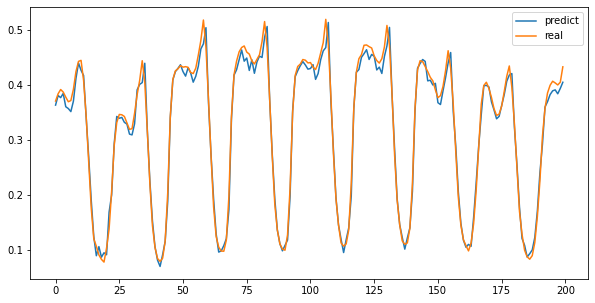

In [18]:
# Prediction for test_set
test_x = test_x.view(test_x.shape[0], time_steps, features).to(DEVICE)
test_y.to(DEVICE)

test_y_hat = model.predict(test_x)
vls = loss_func(test_y_hat.squeeze(),test_y)
test_ls = vls.item() / valid_x.shape[0]
print(f'loss:{test_ls}')
plt.figure(figsize=(10,5))
plt.plot(test_y_hat.cpu().numpy()[:200],label='predict')
plt.plot(test_y.cpu().numpy()[:200],label='real')
plt.legend()